In [1]:
import plotly.graph_objects as go
import datetime
from datetime import datetime
import random
import calendar
import time
import tensorflow as tf
from subprocess import call
from sklearn import tree
import sklearn
from scipy import signal
from matplotlib.lines import Line2D
import statsmodels.tsa.stattools as ts
import matplotlib.ticker as mtick
import matplotlib.collections as collections
from numpy import linalg
from IPython.display import Image
import os
import graphviz
import sys
import csv
import pandas as pd 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import numpy as np
import warnings
from sklearn.tree import export_graphviz
from sklearn import datasets
warnings.filterwarnings("ignore")
import math
import operator
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm
from sklearn import preprocessing
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy import stats
from copy import deepcopy
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_validate

from WindPy import w
w.start()
#趋势划分函数

def und(data, l1, l2):
    i = 0
    res = [0] * len(data)

    while i < len(data)-1:
        if i + l1 >= len(data) - 1:
            for j in range(i, len(data)):
                res[j] = res[i]
            break
        cur = data[i]
        
        next_id = min([(data).index(max(data[i+1+l1:i+1+l2])), data.index(min(data[i+1+l1:i+1+l2]))])
        res[i:next_id+1] = [- (-1) ** (data[next_id] > data[i])] * (next_id + 1 - i)
        i = next_id
    return res

#清理重复的月份
def date_clean(date,data):
    date_res = [date[0]]
    data_res = [[i[0]] for i in data]
    
    last = date[0]
    
    for i in range(len(date[1:])):
        cur = date[i]
        if cur.month != last.month:
            date_res.append(cur)
            for j in range(len(data_res)):
                data_res[j].append(data[j][i])
        last = date[i]

    return date_res, data_res

#移动平均线MA
def ma(data, l_ma):
    res = []
    for i in range(l_ma-1,len(data)):
        res.append(np.mean(data[i-l_ma+1:i+1]))
    return res

#ROCSMA变化率移动平均
def rocsma(d1,i1,l_roc,l_sma):
    res = 0
    for x in range(l_sma):
        res += (d1[i1-x-1]/d1[i1-x-l_sma-1]-1)/l_sma
    return res

#KST公式
def kst(d2,i2,roc_l1,roc_l2,roc_l3,roc_l4,sma_l1,sma_l2,sma_l3,sma_l4):
    rocma1 = rocsma(d2,i2,roc_l1,sma_l1)
    rocma2 = rocsma(d2,i2,roc_l2,sma_l2)
    rocma3 = rocsma(d2,i2,roc_l3,sma_l3)
    rocma4 = rocsma(d2,i2,roc_l4,sma_l4)
    return (rocma1 * 1 + rocma2 * 2 + rocma3 * 3 + rocma4 * 4)
    
#获取下个月末
def next_month(date):
    if date.month == 12:
        res = date.replace(year = date.year + 1, month = 1, day = calendar.monthrange(int(date.year+1), 1)[1])
        
    else:
        res = date.replace(month = date.month + 1, day = calendar.monthrange(int(date.year), date.month + 1)[1])
        
    return res

#相对强度
def rel_str(data, i1, i2):
    return (np.array(data[i1])/np.mean(data[i1])) / (np.array(data[i2])/np.mean(data[i2]))

#斜率
def slope(data):
    res = [0]
    for i in range(1,len(data)):
        res.append(-(-1) ** (data[i]>data[i-1]))
    res[0] = res[1]
    return res

#训练与验证集
def trvd(x, y, ratio):
    train_x = x[:int(len(x)*ratio)]
    valid_x = x[int(len(x)*ratio):]
    train_y = y[:int(len(x)*ratio)]
    valid_y = y[int(len(x)*ratio):]
    
    print(len(train_x), len(valid_x), len(train_y), len(valid_y))
    return train_x, valid_x, train_y, valid_y

#交叉变换趋势
def cross(d1,d2,cd):
    comp = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    res = [-comp[0]]
    c = 0
    
    for i in range(1,len(comp)):
        if comp[i] * comp[i-1] == -1 and c == 0:
            sl1 = -(-1)**(d1[i]>d1[i-1])
            sl2 = -(-1)**(d2[i]>d2[i-1])
            res.append(sl1*sl2)
            c += cd
        else:
            res.append(res[-1])
            c = max(0,c-1)
    return res

#大小对比
def comp(d1,d2):
    res = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    return res

#标准化
def std(data):
    res = []
    for i in range(len(data)):
        res.append((data[i] - np.mean(data[:i+1]))/np.mean(data[:i+1]))
    return res

#普林格经济周期
def pring(b,s,c):
    if b == 1 and s == c == -1:
        return -3
    if b == s == 1 and c == -1:
        return -1
    if b == s == c == 1:
        return 1
    if b == -1 and s == c == 1:
        return 3
    if b == s == -1 and c == 1:
        return 1
    if b == s == c == -1:
        return -1
    else:
        return 0

def dupe_legend(label, color):
    line = Line2D([0], [0], linestyle='none', mfc= 'white',
                mec=color, marker=r'$\mathregular{{{}}}$'.format(label))
    return line

#平滑折线
def smooth(data):
    for i in range(len(data)-4):
        if data[i] * data[i+2] == 1 and data[i] * data[i+1] == -1:
            data[i+1] = data[i]
        elif data[i] * data[i+3] == 1 and all(data[i+1:i+3]) != data[i]:
            for j in range(2):
                data[i+j+1] = data[i]
        elif data[i] * data[i+4] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(3):
                data[i+j+1] = data[i]
    return data

def data_pro(data,l,std_id):
    df = []
    #从第l个周期开始
    for i in range(l-1,len(date)):
        temp = []

        for j in range(len(data)):
            i = int(i)
            j = int(j)
            #选取第j组第i+l时间点前l长度的数据
            il = data[j][i-l+1:i+1]

            #第i+l时间点前l长度的涨跌幅度及方向————0
            temp.append(il[-1]/il[0]-1)

            #第i+l时间点前l长度内的最大波动幅度————1
            temp.append(((max(il)-min(il))/np.mean(il)))

            #第i+l时间点前l长度内的反转频率————2
            spike = 0
            dirc = -(-1) ** (il[1] > il[0]) 
            for k in range(1,l):
                spike += (-(-1) ** (il[k] > il[k-1]) != dirc)
                dirc = -(-1) ** (il[k] > il[k-1])
            temp.append(spike/l)

            if std_id == 1:
                #第i+l时间点l个时长的移动平均值，并根据之前的平均值标准化————3
                temp.append(np.mean(il)/np.mean(data[j][:i])-1)    

                #第i+l时间点的数据，并根据之前的平均值标准化————4
                temp.append(data[j][i]/np.mean(data[j][:i])-1)

            else:

                #第i+l时间点l个时长的移动平均值————3
                temp.append(np.mean(il))    

                #第i+l时间点的数据————4
                temp.append(data[j][i])

            il = data[j][i-6+1:i+1]
            if std_id == 1:
                #第i+l时间点l个时长的移动平均值，并根据之前的平均值标准化————5
                temp.append(np.mean(il)/np.mean(data[j][:i])-1)    

            else:

                #第i+l时间点l个时长的移动平均值————5
                temp.append(np.mean(il))    

            il = data[j][i-9+1:i+1]
            if std_id == 1:
                #第i+l时间点l个时长的移动平均值，并根据之前的平均值标准化————6
                temp.append(np.mean(il)/np.mean(data[j][:i])-1)    

            else:

                #第i+l时间点l个时长的移动平均值————6
                temp.append(np.mean(il))    


        df.append(temp)
    return df

def smooth2(data):
    for i in range(len(data)-5):
        if data[i] * data[i+5] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(4):
                data[i+j+1] = data[i]
    return data
    
def date2num(date):
    d8 = []
    for i in range(len(date)):
        d8.append(int((date[i] - date[0]).days))
    return d8
    
def find1y(date):
    last = date[0]
    for i in range(len(date)):
        cur = date[i]
        if cur.year != last.year:
            return i
        last = date[i]
######################################评估方式

#准确度计算
def acc(d1,d2):
    return round(sum(np.array(d1) == np.array(d2))/ len(d1),3)

#收益率计算
def profit(data, ud):
    money = 1
    num = 0
    prt = 0   #显示买卖记录
    for i in range(len(data)):
        if ud[i] == 1 and num == 0:
            if prt:
                print('in', date[11:][i], 'money', money, 'num', num, 'price', data[i])
            num = money/data[i]
            money = 0
        if ud[i] != 1 and money == 0:
            if prt:
                print('out', date[11:][i], 'money', money, 'num', num, 'price', data[i])
            money = num * data[i]
            num = 0
    if prt:
        print('结果',max(money,num*data[-1]))
    return max(money,num*data[-1])

#复杂度计算
def cpx(x):
    res = 1
    dirc = x[0]
    for i in range(len(x)):
        if x[i] != dirc:
            res += 1
            dirc = x[i]
    return res/len(x)


def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.ewma(timeSeries, span=size)

    timeSeries.plot(color='blue', label='Original')
    rolmean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

'''
　　Unit Root Test
   The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
   root, with the alternative that there is no unit root. That is to say the
   bigger the p-value the more reason we assert that there is a unit root
'''
def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()
    
def tsplot(y, lags=None, figsize=(10,8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):#定义局部样式
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)#自相关系数ACF图
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)#偏相关系数PACF图
        sm.qqplot(y, line='s', ax=qq_ax)#QQ图检验是否是正太分布
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return
    

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


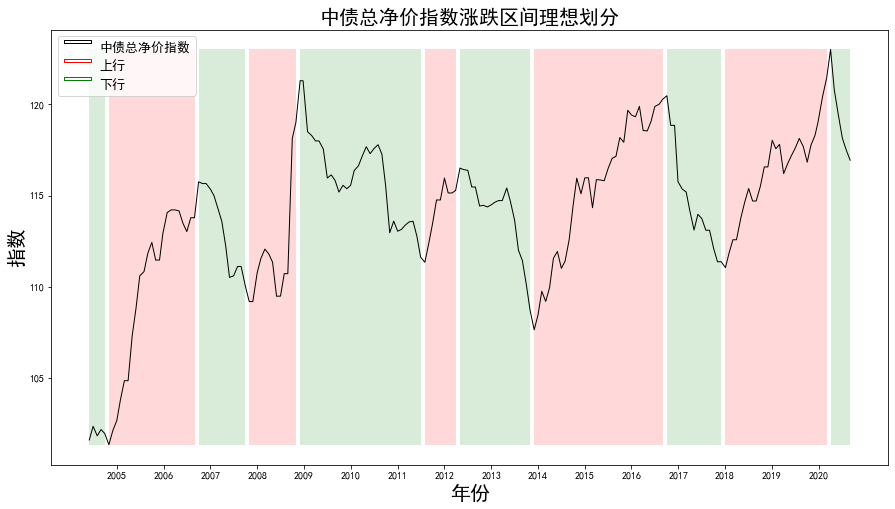

理想收益率 1.534


In [32]:
int_list = [['M0020188','股票'],['S0105896','商品'],['M0265832','中债总净价指数']]

#起止时间
t0 = '2004-06-01'
t1 = '2020-10-01'

#指数取值周期
dic = {'D':'天', 'W':'周', 'M':'月', 'Q':'季度', 'S':'半年', 'Y':'年'}
prd = 'M'

#移动平均线平均时长
l = 12

ind_list = []
for i in int_list:
    ind_list.append(i[0])
    
og = w.wsd(ind_list, 'close', t0, '-1D', Period = prd, Fill = 'Previous')

#训练比例
r = .5

#指数与日期
date, data = date_clean(og.Times, og.Data)
date_s = [str(i) for i in date]

df = []
d8 = date2num(date)
################################    

ud = und(data[2],3,24)
base_cpx = cpx(ud)
    
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('中债总净价指数涨跌区间理想划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[2], color='black', linewidth = 1, label = '中债总净价指数')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8, ymin=min(data[2]), ymax=max(data[2]), where=np.array(ud) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8, ymin=min(data[2]), ymax=max(data[2]), where=np.array(ud) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

new_legends = ["-", "-", "-"]
markers = ['-','-','-']
colors = ['black', 'red', 'green']

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()
print('理想收益率',round(profit(data[2][:-24],ud[:-24]),3))
####################
std_id = 1
df = data_pro(data, l, std_id)

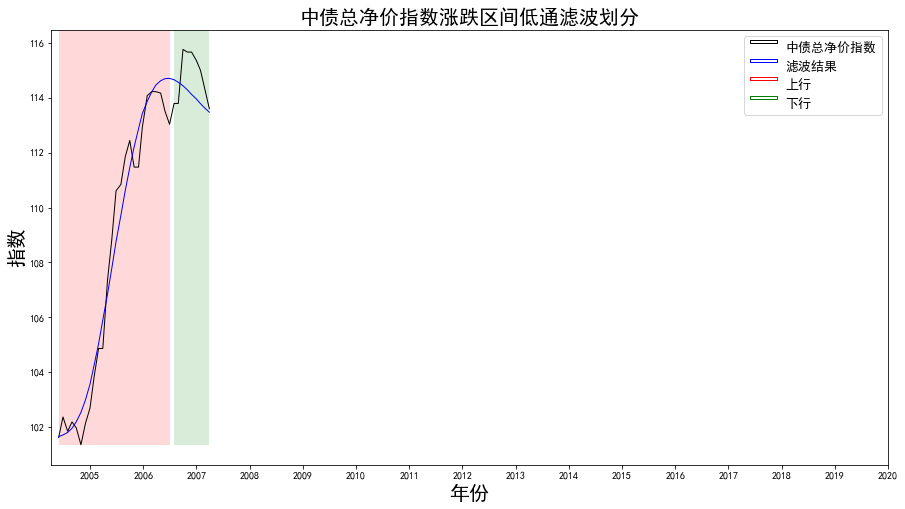

日期 2007-05-31
收益率 1.12
相对收益率 0.98
准确率 0.8
复杂度 1.018


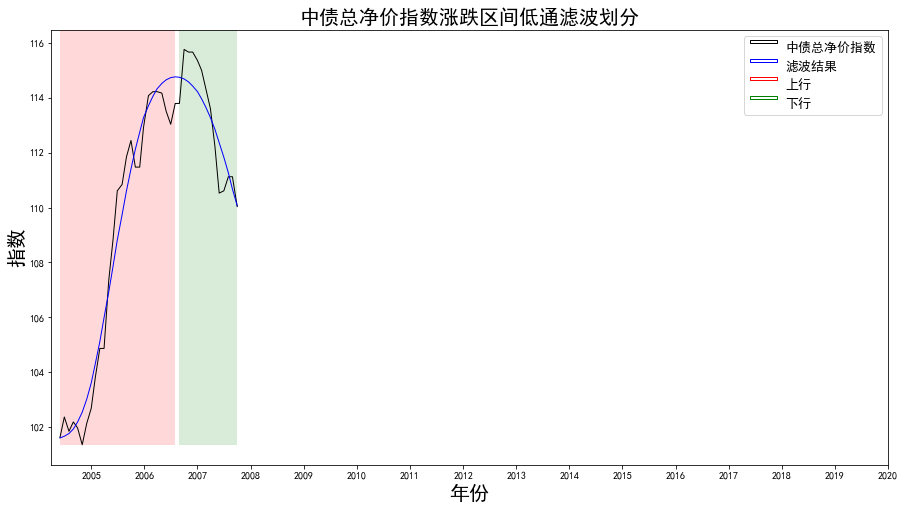

日期 2007-11-30
收益率 1.12
相对收益率 0.98
准确率 0.854
复杂度 0.869


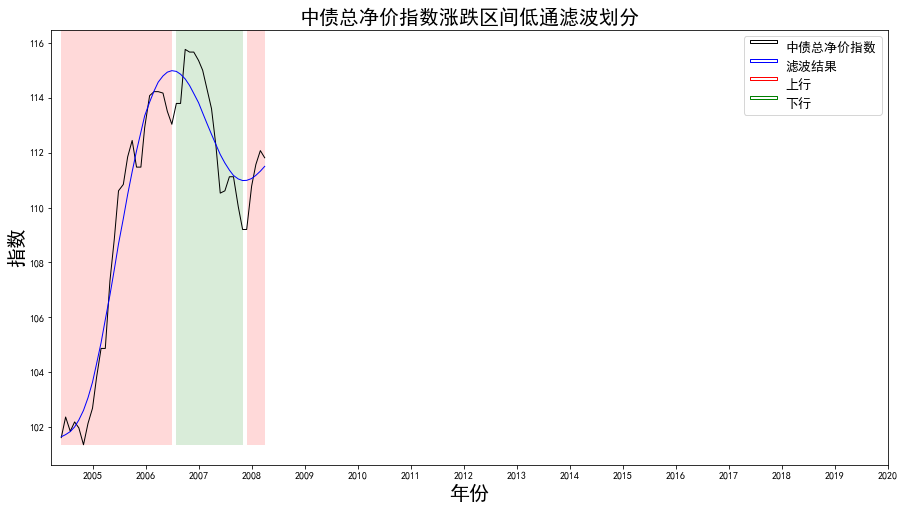

日期 2008-05-30
收益率 1.147
相对收益率 0.98
准确率 0.83
复杂度 1.137


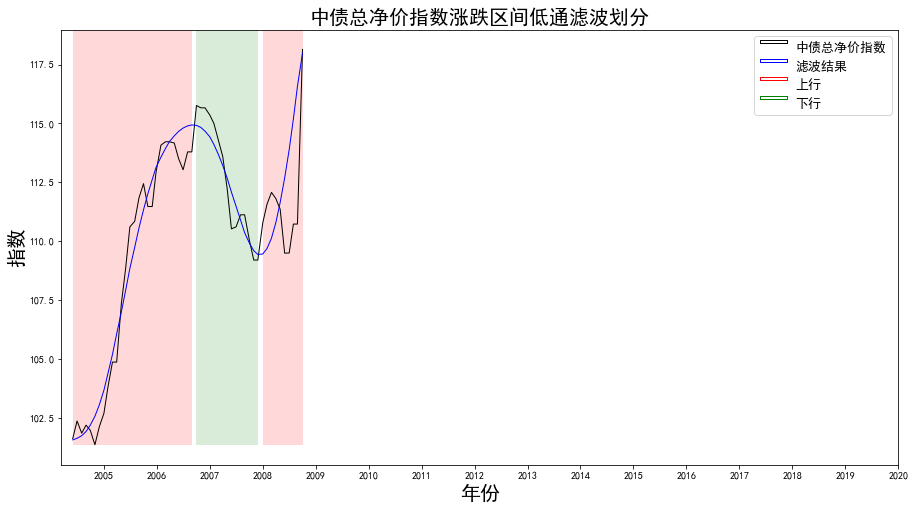

日期 2008-11-28
收益率 1.215
相对收益率 0.983
准确率 0.868
复杂度 1.009


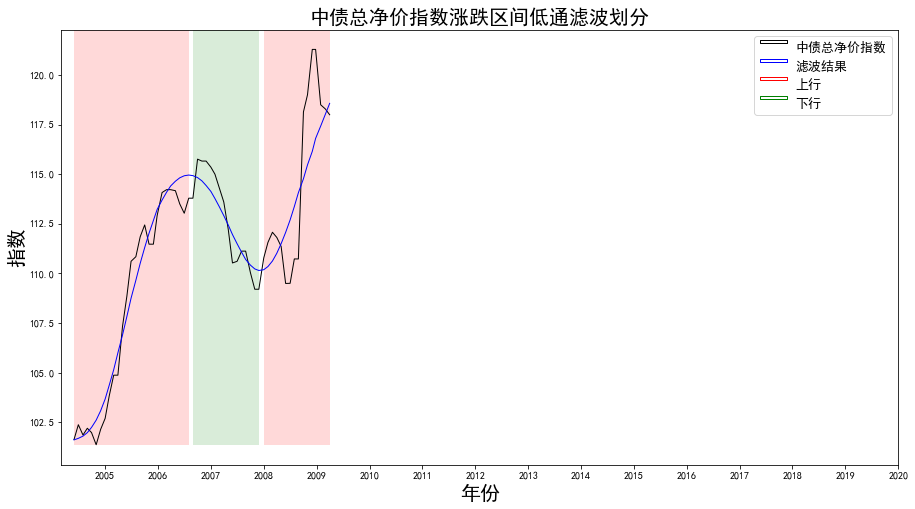

日期 2009-05-27
收益率 1.193
相对收益率 0.94
准确率 0.78
复杂度 0.906


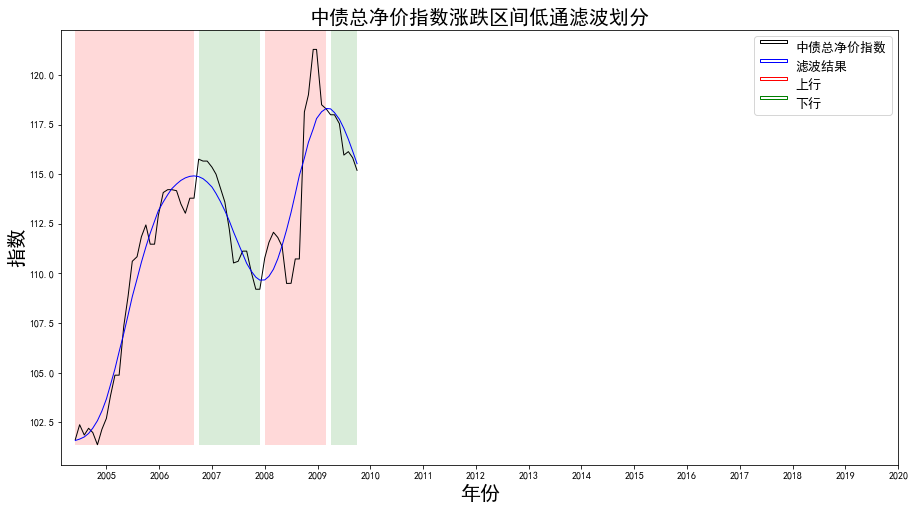

日期 2009-11-30
收益率 1.213
相对收益率 0.956
准确率 0.831
复杂度 1.097


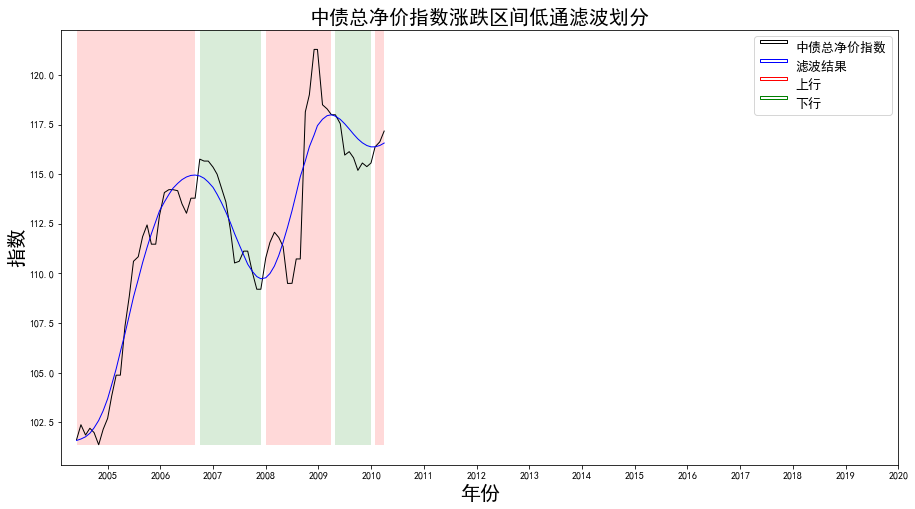

日期 2010-05-31
收益率 1.222
相对收益率 0.963
准确率 0.789
复杂度 1.255


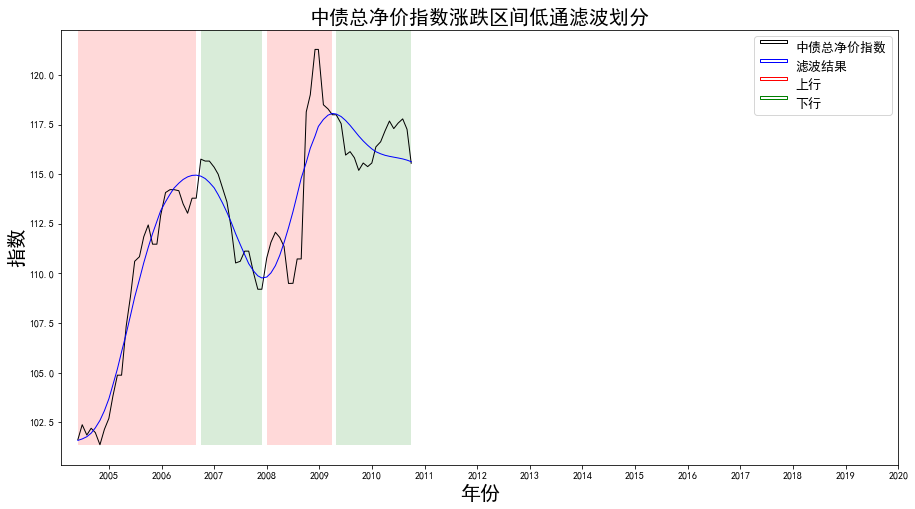

日期 2010-11-30
收益率 1.213
相对收益率 0.956
准确率 0.844
复杂度 0.926


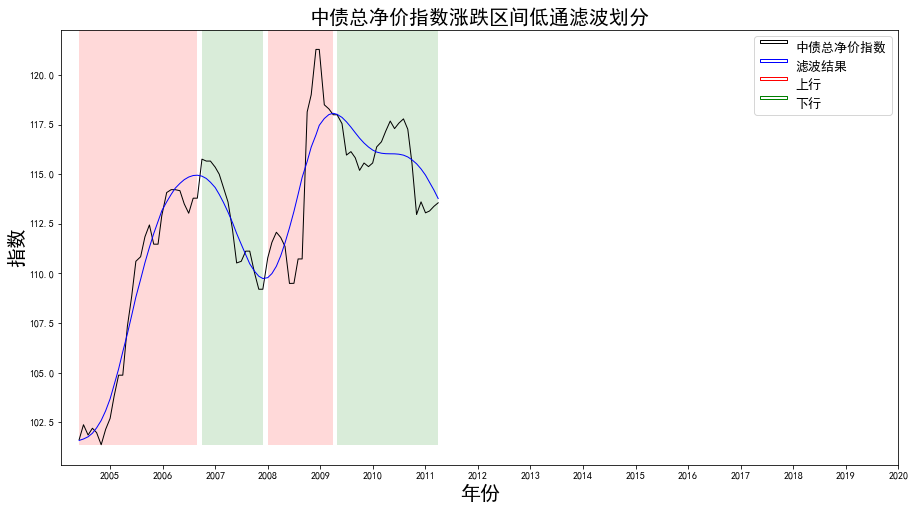

日期 2011-05-31
收益率 1.213
相对收益率 0.956
准确率 0.855
复杂度 0.859


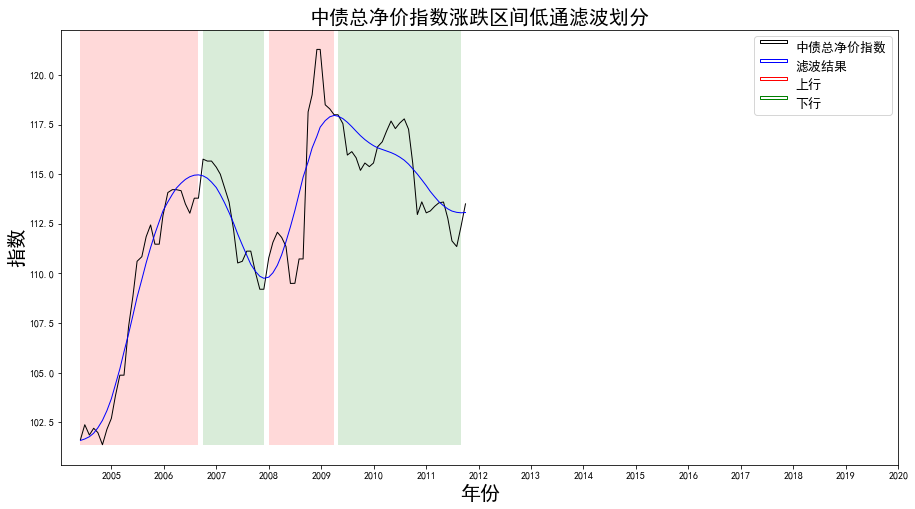

日期 2011-11-30
收益率 1.213
相对收益率 0.938
准确率 0.843
复杂度 1.001


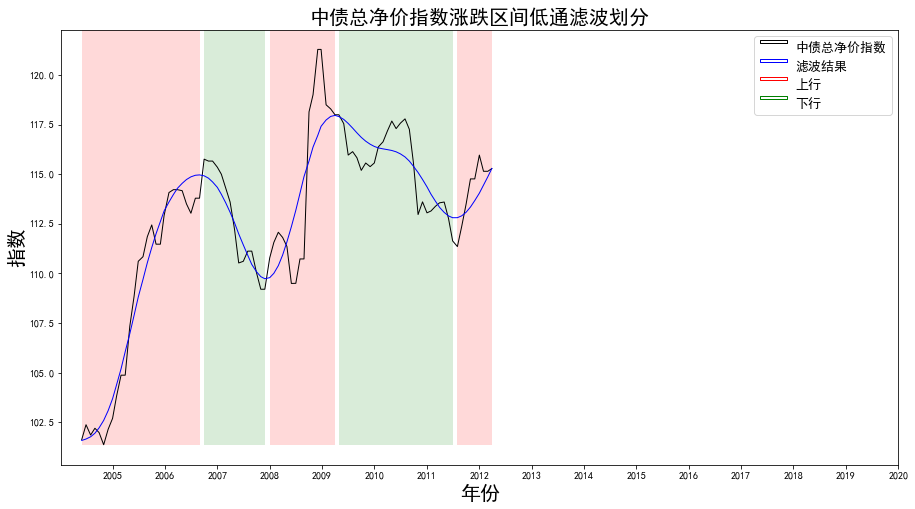

日期 2012-05-31
收益率 1.256
相对收益率 0.956
准确率 0.874
复杂度 0.938


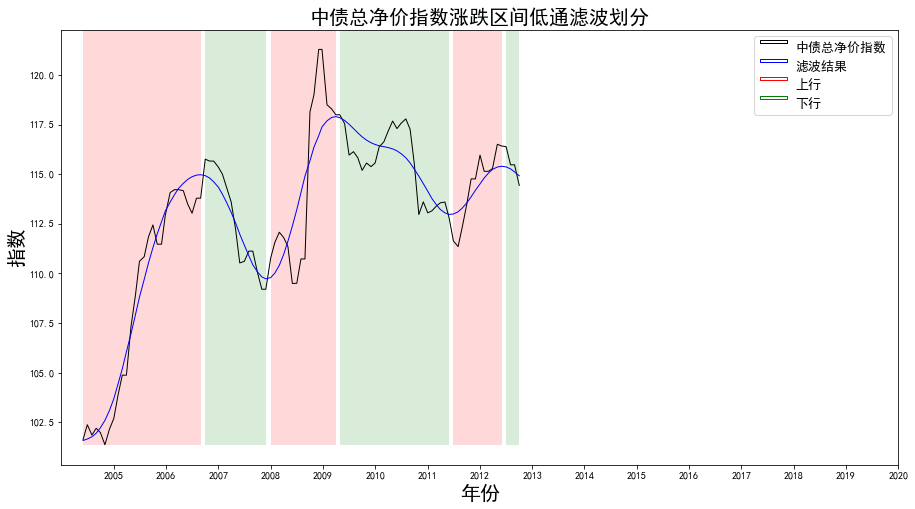

日期 2012-11-30
收益率 1.265
相对收益率 0.953
准确率 0.851
复杂度 1.059


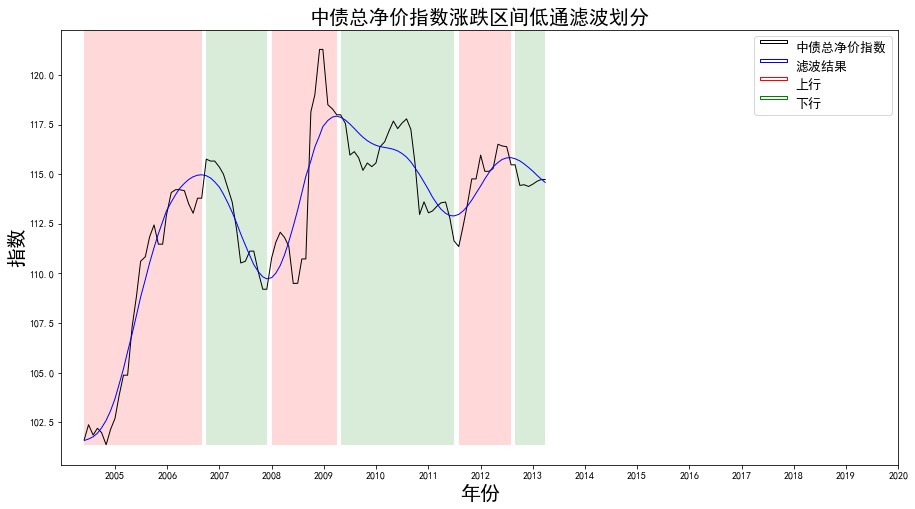

日期 2013-05-31
收益率 1.258
相对收益率 0.948
准确率 0.85
复杂度 0.999


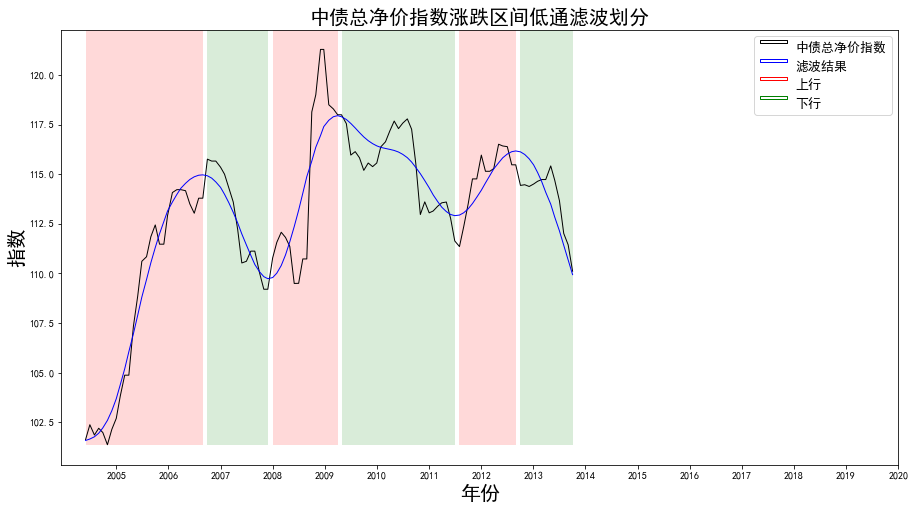

日期 2013-11-29
收益率 1.247
相对收益率 0.939
准确率 0.85
复杂度 0.946


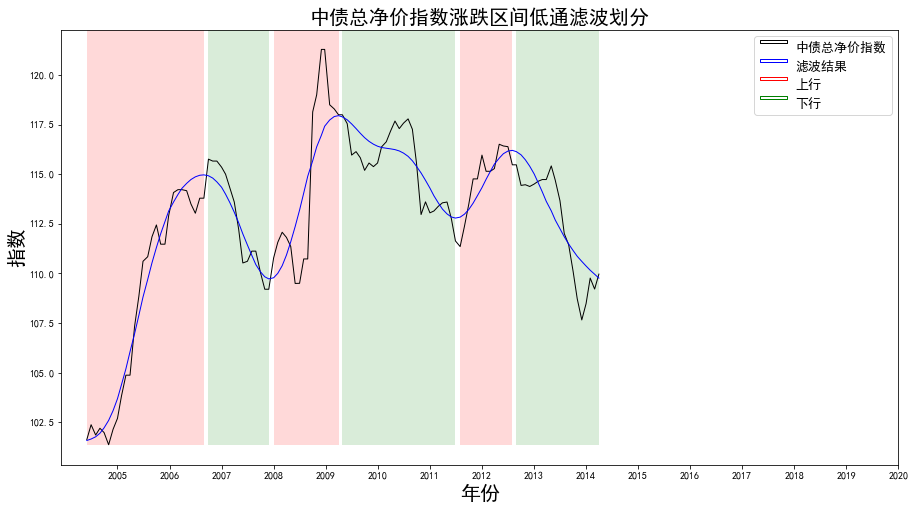

日期 2014-05-30
收益率 1.258
相对收益率 0.928
准确率 0.824
复杂度 0.898


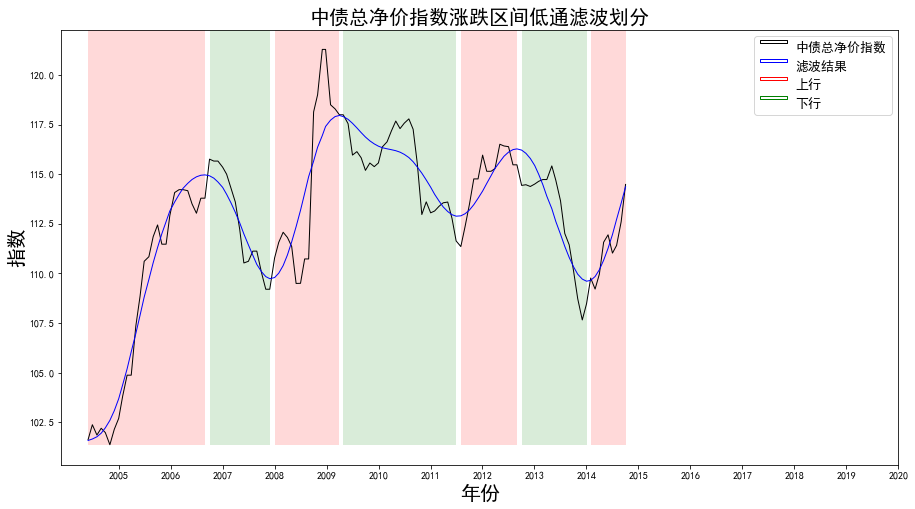

日期 2014-11-28
收益率 1.301
相对收益率 0.921
准确率 0.848
复杂度 0.998


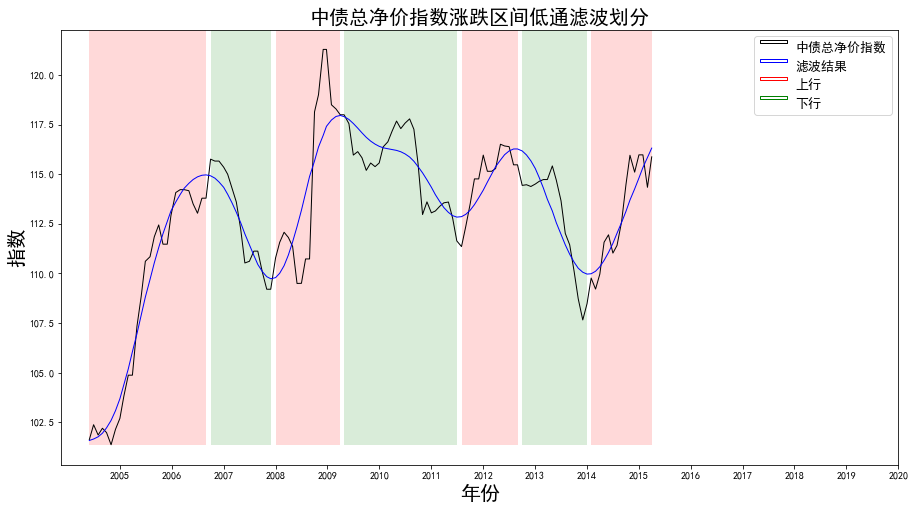

日期 2015-05-29
收益率 1.317
相对收益率 0.921
准确率 0.855
复杂度 0.952


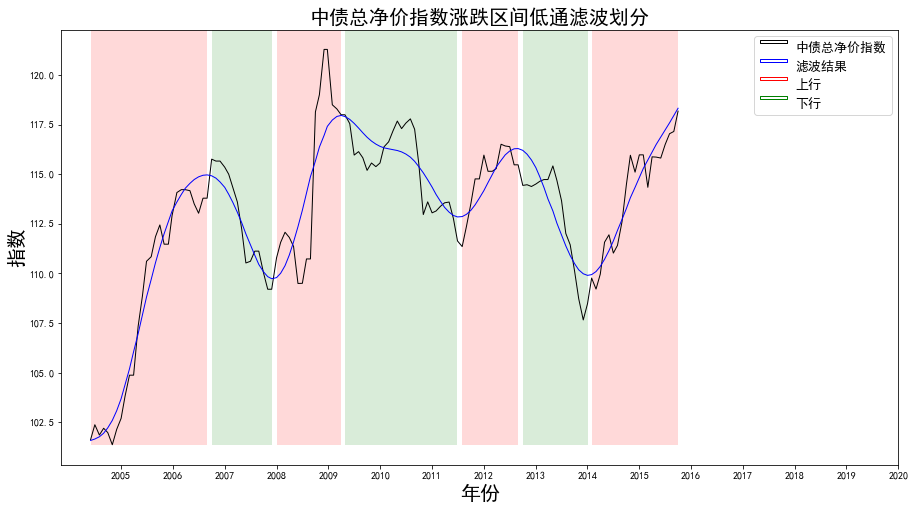

日期 2015-11-30
收益率 1.343
相对收益率 0.921
准确率 0.861
复杂度 0.91


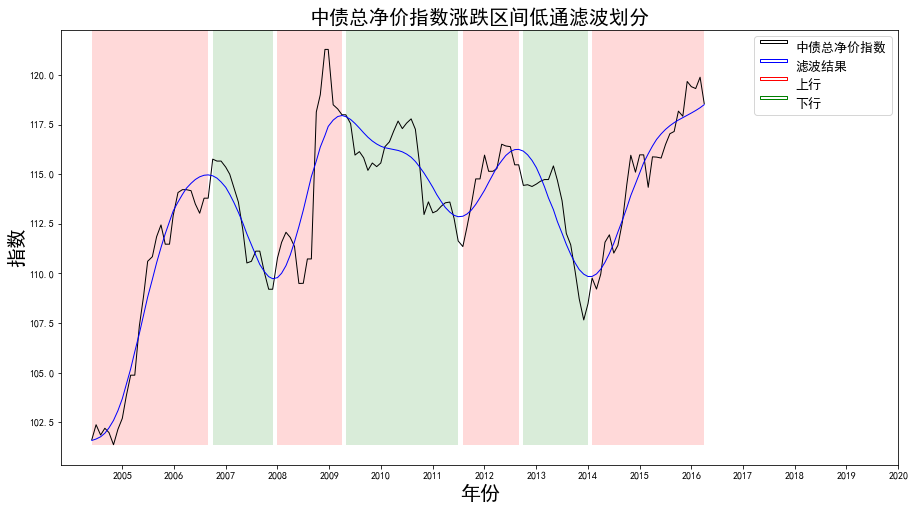

日期 2016-05-31
收益率 1.347
相对收益率 0.921
准确率 0.867
复杂度 0.872


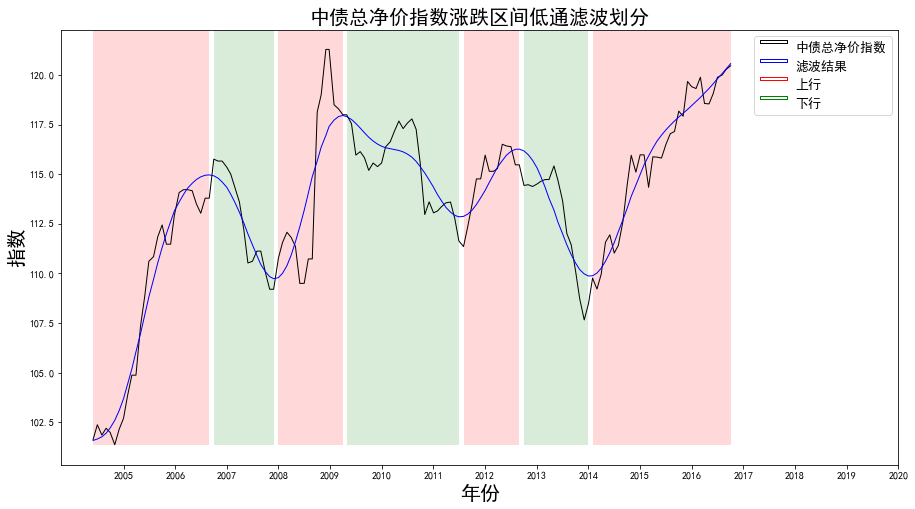

日期 2016-11-30
收益率 1.369
相对收益率 0.921
准确率 0.866
复杂度 0.837


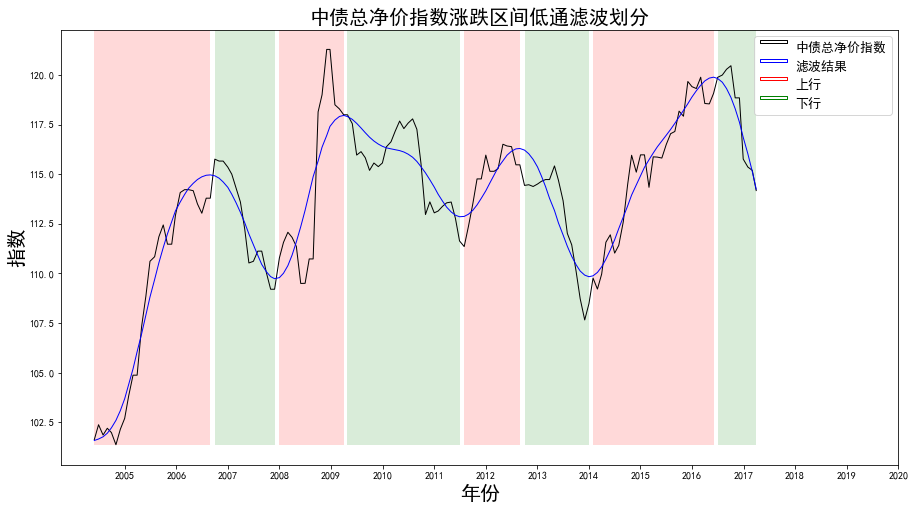

日期 2017-05-31
收益率 1.362
相对收益率 0.917
准确率 0.858
复杂度 0.92


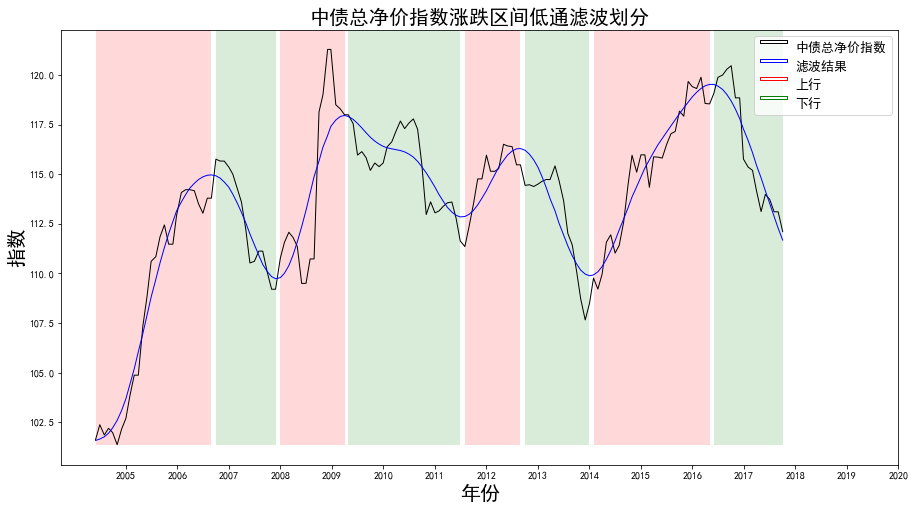

日期 2017-11-30
收益率 1.353
相对收益率 0.911
准确率 0.857
复杂度 0.885


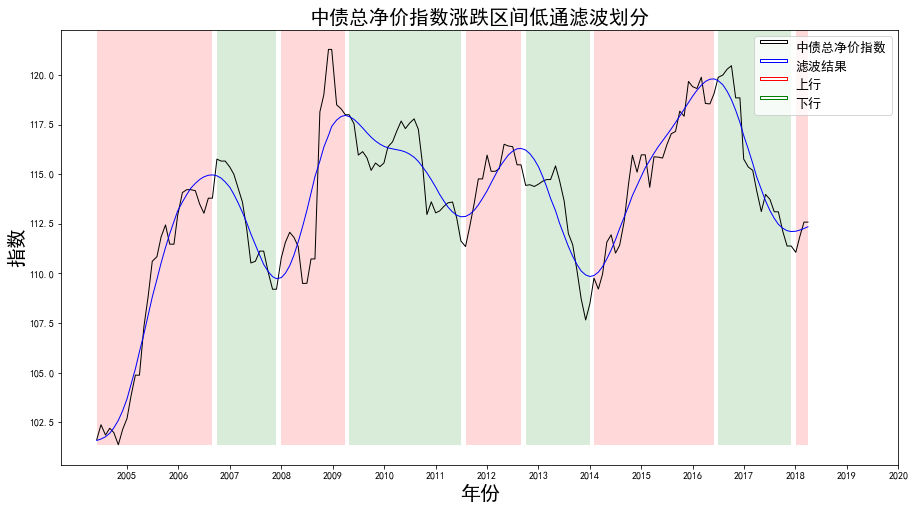

日期 2018-05-31
收益率 1.381
相对收益率 0.917
准确率 0.868
复杂度 0.96


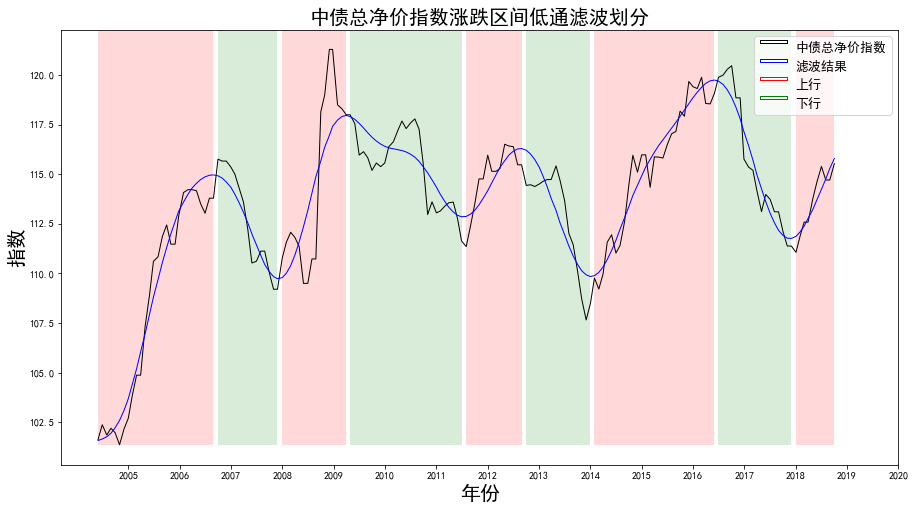

日期 2018-11-30
收益率 1.417
相对收益率 0.917
准确率 0.873
复杂度 0.927


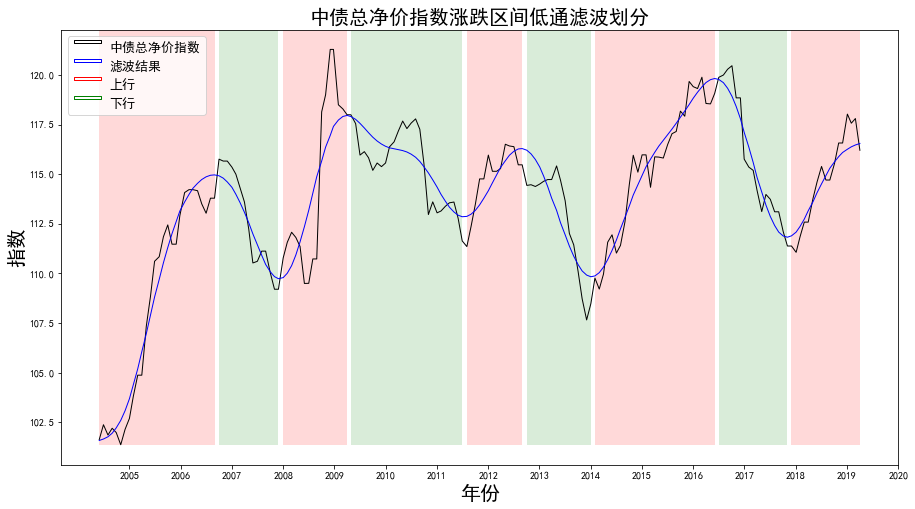

日期 2019-05-31
收益率 1.421
相对收益率 0.914
准确率 0.872
复杂度 0.896


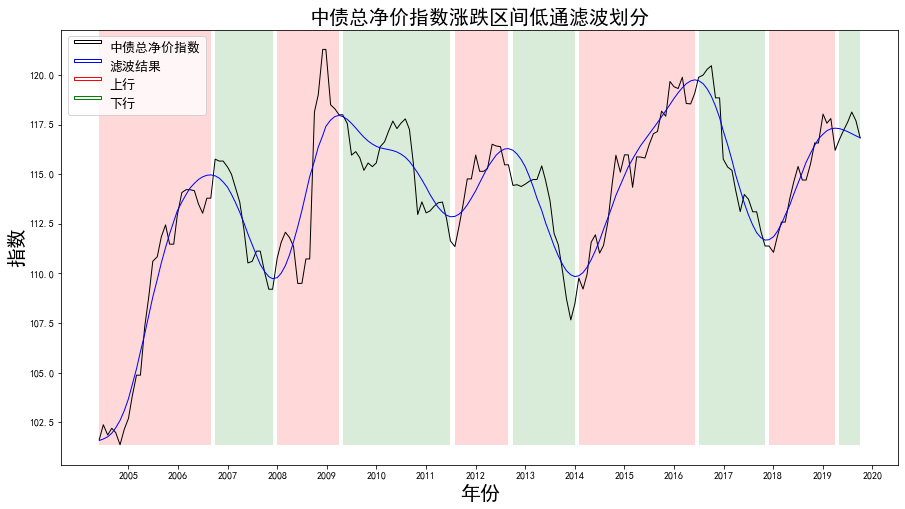

日期 2019-11-29
收益率 1.428
相对收益率 0.914
准确率 0.843
复杂度 0.963


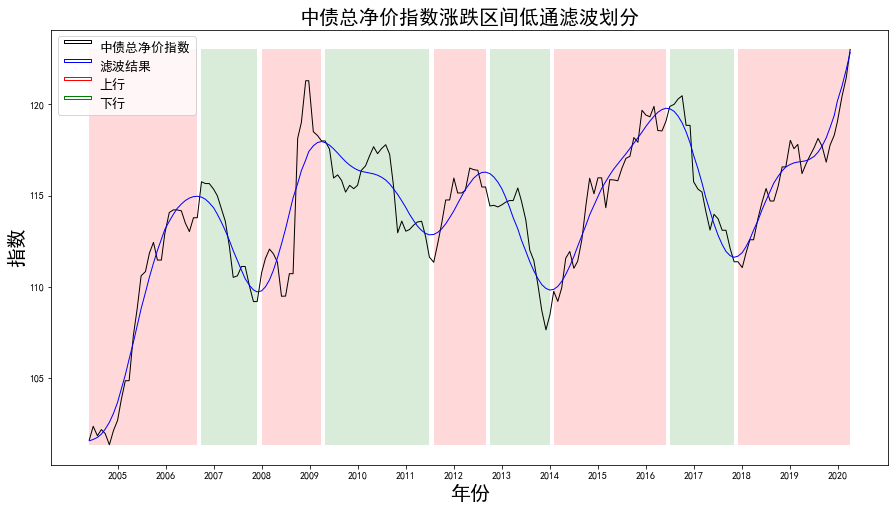

日期 2020-05-29
收益率 1.504
相对收益率 0.914
准确率 0.874
复杂度 0.84


In [74]:
frq = .1

for i in range(35,len(date),6):
    
    fdata = signal.filtfilt(signal.butter(8, frq, 'lowpass')[0], signal.butter(8, frq, 'lowpass')[1], data[2][:i])
    ud_f = slope(fdata)
    plt.rcParams['font.family']=['SimHei']
    fig, ax = plt.subplots(figsize=(15,8))
    ax.set_title('中债总净价指数涨跌区间低通滤波划分',fontproperties='SimHei', size = 20)
    ax.plot(d8[:i], data[2][:i], color='black', linewidth = 1, label = '中债总净价指数')
    ax.plot(d8[:i], fdata, color='blue', linewidth = 1, label = '滤波结果')
    plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
    plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
    plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)
    collection = collections.BrokenBarHCollection.span_where(
    d8[:i], ymin=min(data[2]), ymax=max(data[2]), where=np.array(ud_f) == 1, facecolor='red', alpha=.15, label = '上行')
    ax.add_collection(collection)
    collection = collections.BrokenBarHCollection.span_where(
    d8[:i], ymin=min(data[2]), ymax=max(data[2]), where=np.array(ud_f) == -1, facecolor='green', alpha=.15, label = '下行')
    ax.add_collection(collection)
    colors = ['black', 'blue','red', 'green']
    new_legends = ["-"] * len(colors)
    markers = ['-'] * len(colors)
    _, labels = ax.get_legend_handles_labels()
    duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
    ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)
    plt.show
    
    plt.pause(1)
    p1 = round(profit(data[2][:i], ud_f),3)
    rp1 = round(profit(data[2][:i], ud_f)/profit(data[2][:i], ud[:i]),3)
    a1 = round(acc(ud_f,ud[:i]),3)
    c1 = round(cpx(ud_f)/base_cpx,3)
    print('日期',date[i])
    print('收益率',p1)
    print('相对收益率',rp1)
    print('准确率',a1)
    print('复杂度',c1)
    
